# Lichess data exploration

Lichess is the 2nd largest online chess platform with about 730,000 games being played each day as of August 2018. Lichess relies entirely on donated money for the maintainance of its servers and for paying its programmers. The software running Lichess is open source.

Lichess freely make available all the data on every game that is played on the platform since January 2013. To give an idea of the size of such data, there was 22,635,642 games played in August 2018, and the size of the extracted file containing the informations for this month only is about 46 GB.

### What this notebook is about

The data contain features such as the opening used by the players, both players Elo scores, the result of the game and so forth. We can then answer interesting questions such as: "What is the most popular opening, for players of a given strengths?" or "What are the most effective openings for a given level of play?". This notebook is about answering such questions.

As the data size is large, we are going to use Spark. Spark is a open-source distributed cluster-computing framework, which uses the MapReduce principle to perform operation on datasets with lots of computers. 

The above study has been done with Spark on a single computer. The reasons for this are:
 - Spark have lower memory consumption than single-node PyData tools, as it does not require loading all the data for processing. Given the size of the data, loading it entirely would have been impossible on the used device.
 - The code is easily adaptable to a cluster of computers if needed, hence scalable

Since Spark is used with a single node, the installation of spark on a multi-node cluser in not shown.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b> Note: </b>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


## Structure of the data

The data is in the ```.pgn``` format, which displays the chess game PGN code representing both players move, along with the meta-data associated to the game. Here is a sample of data:

In [1]:
f = open('sample.txt')
f.readlines(500)

['[Event "Rated Blitz game"]\n',
 '[Site "https://lichess.org/XGG9YsWI"]\n',
 '[White "caxan"]\n',
 '[Black "b66lz6bub"]\n',
 '[Result "1-0"]\n',
 '[UTCDate "2017.12.31"]\n',
 '[UTCTime "23:03:16"]\n',
 '[WhiteElo "1792"]\n',
 '[BlackElo "1803"]\n',
 '[WhiteRatingDiff "+10"]\n',
 '[BlackRatingDiff "-11"]\n',
 '[ECO "C42"]\n',
 '[Opening "Russian Game: French Attack"]\n',
 '[TimeControl "300+0"]\n',
 '[Termination "Time forfeit"]\n',
 '\n',
 '1. e4 { [%clk 0:05:00] } e5 { [%clk 0:05:00] } 2. Nf3 { [%clk 0:04:59] } Nf6 { [%clk 0:04:58] } 3. Nxe5 { [%clk 0:04:56] } d6 { [%clk 0:04:57] } 4. Nf3 { [%clk 0:04:52] } Nxe4 { [%clk 0:04:57] } 5. d3 { [%clk 0:04:50] } Nf6 { [%clk 0:04:49] } 6. d4 { [%clk 0:04:48] } Be7 { [%clk 0:04:43] } 7. Bd3 { [%clk 0:04:46] } b6 { [%clk 0:04:40] } 8. O-O { [%clk 0:04:44] } Bb7 { [%clk 0:04:39] } 9. Re1 { [%clk 0:04:38] } Nc6 { [%clk 0:04:37] } 10. c3 { [%clk 0:04:34] } h6 { [%clk 0:04:33] } 11. Qe2 { [%clk 0:04:31] } Qd7 { [%clk 0:04:30] } 12. Bb5 { [%clk 0:0

The meta-data is comprised of 15 fields plus the chess moves with clock timestamps displayed below it. The fields are:
 - __Event__: the context of the game (competition, simple rated game...)
 - __White & Black__: the players nicknames
 - __Result__: the outcome of the game
 - __UTCDate & UTCTime__: the time and date at which the game is played
 - __WhiteElo and WhiteElo__: the players Elo scores (i.e. strengths)
 - __WhiteRatingDiff & BlackRatingDiff__: the variation of players scores due to the game
 - __ECO & Opening__: the opening used (ECO is simply a code for the opening)
 - __TimeControl__: the clock settings for the game (time for each player + added time per move)
 - __Termination__: the way the game has ended (Forfeit, Normal, No time left...)



In [96]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b> Note: </b>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Data manipulation

We are first going to focus on the meta-data. Our goal is to use Spark in order to get a Spark DataFrame in which each row contains the meta-data for a game. From there we are simply going to query the DataFrame with the Spark SQL Context to question the data. First we need to set up PySpark. The data is then loaded into a RDD object by using the ```textFile``` method. RDD stands for Resilient Distributed Dataset, these are the data elements that are run on multiple nodes to do parallel processing on a cluster.
We can access the newly created RDD with the ```take```method.

In [7]:
# # Setting up PySpark
from pyspark import SparkConf, SparkContext
conf = (SparkConf()
         .setMaster("local")
         .setAppName("Lichess")
         .set("spark.executor.memory", "8g")
         .set("spark.executor.heartbeatInterval","3000s")
         .set("spark.network.timeout", "3600s"))     
sc = SparkContext('local[2]', '', conf=conf)

# Loading the RDD containing sample data
rdd = sc.textFile("sample.txt")

# Displaying sample data
rdd.take(20)

['[Event "Rated Blitz game"]',
 '[Site "https://lichess.org/XGG9YsWI"]',
 '[White "caxan"]',
 '[Black "b66lz6bub"]',
 '[Result "1-0"]',
 '[UTCDate "2017.12.31"]',
 '[UTCTime "23:03:16"]',
 '[WhiteElo "1792"]',
 '[BlackElo "1803"]',
 '[WhiteRatingDiff "+10"]',
 '[BlackRatingDiff "-11"]',
 '[ECO "C42"]',
 '[Opening "Russian Game: French Attack"]',
 '[TimeControl "300+0"]',
 '[Termination "Time forfeit"]',
 '',
 '1. e4 { [%clk 0:05:00] } e5 { [%clk 0:05:00] } 2. Nf3 { [%clk 0:04:59] } Nf6 { [%clk 0:04:58] } 3. Nxe5 { [%clk 0:04:56] } d6 { [%clk 0:04:57] } 4. Nf3 { [%clk 0:04:52] } Nxe4 { [%clk 0:04:57] } 5. d3 { [%clk 0:04:50] } Nf6 { [%clk 0:04:49] } 6. d4 { [%clk 0:04:48] } Be7 { [%clk 0:04:43] } 7. Bd3 { [%clk 0:04:46] } b6 { [%clk 0:04:40] } 8. O-O { [%clk 0:04:44] } Bb7 { [%clk 0:04:39] } 9. Re1 { [%clk 0:04:38] } Nc6 { [%clk 0:04:37] } 10. c3 { [%clk 0:04:34] } h6 { [%clk 0:04:33] } 11. Qe2 { [%clk 0:04:31] } Qd7 { [%clk 0:04:30] } 12. Bb5 { [%clk 0:04:29] } a6 { [%clk 0:04:28] } 13

As we can see, the pgn file is read line by line and the RDD contains a record for each line, is the same way as a Python list. From all the information in the RDD, only a part of it is truly useful to us. First, we are going to get rid of the __WhiteRatingDiff__ and __BlackRatingDiff__ fields, as they are not relevant for our study. The ```select_fields```function is used to remove these rows from the RDD.

Then we get rid of useless characters such as ' [ ' or ' " ', and we get rid of the categories names as we can derive the category of a given line by its position in the RDD. Furthermore, for the upcoming aggregation operation, we are going to add an index to the RDD. The RDD can be saved in order to prevent us to recompute everything if something goes wrong.
Here is the look of the RDD so far with an index and with the categories filtered.

In [8]:
# Custom filter function
def is_relevant(x):
    relevant_fields = ['Event "', 'White "', 'Black "', 'Result "', 'UTCDate "', 'UTCTime "', 'WhiteElo "',
                       'BlackElo "', 'ECO "', 'Opening "', 'TimeControl "', 'Termination "']
    for field in relevant_fields:
        if field in x:
            return True
    return False

# Filtering RDD
rdd_filtered = rdd.filter(lambda x: is_relevant(x))

# zipWithIndex() :  adds an index to the RDD
# ''.join(x[1].split(' ')[1:] :  selects all but the first word of a field, i.e. removing category names from each line
rdd_with_index = rdd_filtered.zipWithIndex().map(lambda x: (x[1], x[0].replace('[', '').replace('"', ''))) \
        .map(lambda x: (x[0], ''.join(x[1].split(' ')[1:])))

# Saving RDD
rdd_with_index.saveAsPickleFile('rdd')

# Displaying sample
rdd_with_index.take(20)

[(0, 'RatedBlitzgame]'),
 (1, 'caxan]'),
 (2, 'b66lz6bub]'),
 (3, '1-0]'),
 (4, '2017.12.31]'),
 (5, '23:03:16]'),
 (6, '1792]'),
 (7, '1803]'),
 (8, 'C42]'),
 (9, 'RussianGame:FrenchAttack]'),
 (10, '300+0]'),
 (11, 'Timeforfeit]'),
 (12, 'RatedBlitzgame]'),
 (13, 'Daniluch]'),
 (14, 'amgad55]'),
 (15, '0-1]'),
 (16, '2017.12.31]'),
 (17, '23:03:16]'),
 (18, '1449]'),
 (19, '1474]')]

Now, the RDD contains all the useful fields for our data exploration. However, as shown, the RDD is merely a sequence of values without any relation to one another. The next step is to group the fields per chess game, i.e. we want each row of the RDD to describe one particular game. Each row should contain a tuple with the meta-data of the given chess game

It is possible to do that as we know that each game is described by __12__ different fields (since we dropped WhiteRatingDiff and BlackRatingDiff). We can derive a field's type from its index by taking the quotient of its division by 12. In our configuration, all fields with index '0' corresponds to the first game, '1' to the second, etc.

Taking each index as a key, we use the ```aggregateByKey``` method to group each record by the modified index, which amounts to grouping . The aggregation function is user-defined and in our case is simply a concatenation of strings. The last steps are to use the ' ] ' character that we purposefully left to split the string data into a tuple, clean the data from the incomplete rows and save the RDD. Let's load back the RDD and perform these operation

In [9]:
# Loading the RDD
rdd_cleaned = sc.pickleFile('rdd')

# Changes each index by the quotient if its division by 12
game_indexed_rdd = rdd_cleaned.map(lambda x: (str(int(x[0]) // 12 + 1), x[1]))

# Aggregation operations
seqOp = (lambda x, y: x + y)
combOp = (lambda x, y: x + y)

# Perform aggregation
temp = game_indexed_rdd.aggregateByKey('', seqOp, combOp)

# Cleaning function for incomplete rows
def clean_rows(p):
    if len(p) >= 12:
        return p
    else:
        return [''] * 13

# Splitting and cleaning RDD
grouped_by_game_rdd = temp.map(lambda x: [x[0]] + x[1].split(']')[:12]).map(lambda p: clean_rows(p))

# Saving RDD
grouped_by_game_rdd.saveAsPickleFile('aggregated')

grouped_by_game_rdd.take(3)

[['4',
  'RatedBlitzgame',
  'Vadim12b',
  'zisv',
  '1-0',
  '2017.12.31',
  '23:03:17',
  '1506',
  '1506',
  'C43',
  'Petrov:ModernAttack',
  '180+0',
  'Normal'],
 ['10',
  'RatedBulletgame',
  'Gokhanalay6565',
  'sosyolog94',
  '0-1',
  '2017.12.31',
  '23:03:18',
  '1448',
  '1600',
  'C34',
  "King'sGambitAccepted,FischerDefense",
  '120+0',
  'Timeforfeit'],
 ['12',
  'RatedStandardgame',
  'korbi',
  'j100',
  '0-1',
  '2017.12.31',
  '23:03:19',
  '2033',
  '1938',
  'A02',
  'BirdOpening',
  '600+0',
  'Normal']]

The RDD can be used converted into a Spark DataFrame, which more convenient to use as we can perform SQL queries on the data. To do that, we load back the RDD and initiate a Spark SQL Context. Then we define the columns of the Spark DataFrame and insert the data from the RDD. 

In [11]:
# Loading back the RDD
rdd_processed = sc.pickleFile('aggregated')

# Initiating the Spark SQL Session
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

from pyspark.sql.types import *
from pyspark.sql.types import Row

# Inserting data from RDD
games_data = rdd_processed.map(lambda p: Row(Index=p[0], Event=p[1], White=p[2], Black=p[3], Result=p[4], UTCDate=p[5],
                            UTCTime=p[6], WhiteElo=p[7], BlackElo=p[8], ECO=p[9], Opening=p[10],
                            TimeControl=p[11], Termination=p[12]))

schemaString = "Index Event White Black Result UTCDate UTCTime WhiteElo BlackElo ECO Opening TimeControl Termination"
fields = [StructField(field_name, StringType(), True) for field_name in schemaString.split()]
schema = StructType(fields)
df = spark.createDataFrame(games_data, schema)

# Saving PySpark Dataframe
df.write.save('chessgames_sample.parquet')

From the raw pgn file that has been loaded at the beginning of the notebook to the current DataFrame, the size of the data has been divided by 25.

In [73]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b> Note: </b>The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Data exploration

We can now start questionning the data. The above code has been used on the January to March 2018 chess raw data, and the processed results are contained in the ```chessgames.parquet``` file. Let's recall the structure of our DataFrame by showing a sample

In [61]:
# df = spark.read.load("chessgames_sample.parquet")
df = spark.read.load("chessgames.parquet")
df.select('Event', 'White', 'Black', 'Result', 'WhiteElo', 'BlackElo', 'Opening', 'TimeControl', 'Termination').show(7)

(UTCDate, UTCTime, Eco and Index columns are not shown for better visualization)

Let's begin by answering some straightforward yet essential questions

### How many chess games do we have?

In [13]:
print('The data contains {} chess games'.format(df.count()))

The data contains 55365465 chess games


### Which players has played the most games?

To answer this question, we need to count the number of times any player name occur in ```White``` column as well as in ```Black``` column. We are going to group the player names by taking their count first for the ```White``` column alone, then for ```Black``` column, and then sum the count columns using a JOIN. Here are the 10 players that played the most games:

In [14]:
# Extracting occurence counts grouped by player name, for black and white
df1 = df.select("White").groupBy("White").count().withColumnRenamed('count', 'white_count').withColumnRenamed('White', 'Player')
df2 = df.select("Black").groupBy("Black").count().withColumnRenamed('count', 'black_count').withColumnRenamed('Black', 'Player')

# Sum of the two tables
players = df1.join(df2, on='Player', how='outer')
players = players.withColumn('total', sum(players[col] for col in ['white_count', 'black_count']))

# Descening order
players = players.orderBy(players.total.desc())

# Save for performance
players.write.save('players_sample.parquet')

# Displaying the top 10 players by number of games played
import pandas as pd
players = spark.read.load('players_sample.parquet')
players.createOrReplaceTempView("players")
query = """SELECT * FROM players ORDER BY total DESC limit 10"""
top_10 = spark.sql(query).toPandas()
top_10

,Player,white_count,black_count,total
0,TheMotherForker,9201,9199,18400
1,blnote,8714,9262,17976
2,ASONINYA,8726,8724,17450
3,Vajk,8680,8682,17362
4,hiitsme,8560,8575,17135
5,DarkestPhoenix,8037,8031,16068
6,pearla_thunder,7919,7963,15882
7,german11,7672,7699,15371
8,martimhernandez,7185,7151,14336
9,tahayildirim,7127,7144,14271


The player having played the most chess games is "TheMotherForker" with 18400 games in 1 month. That's 200 games per day, and 8 games per hour 24/7.

### How many players are involved in these games?

We simply count the number of rows from the previous ```players``` dataframe to get the number of distinct players

In [15]:
print('{} players participated to the games during the considered period.'.format(players.count()))

536590 players participated to the games during the considered period.


### Proportion of games per game type

Chess games are classified by type according to the allocation of time for players. The time control is comprised of a fixed time and an time increment which is added to the total after each move is played. There is a variety to the time controls available in online chess, but we can classify them into several categories:
 - Bullet: 3 minutes or less per player, typically 2 minutes plus 1 second increment
 - Blitz: 10 minutes or less per player. Usually, 3 minutes plus 2 seconds additional time per move is preferred
 - Rapid: Between 10 and 60 minutes per player. For the FIDE World Rapid Championship, each player will have 15 minutes, plus 10 seconds additional time per move
 - Correspondence: Time for each turn can go from one day to 2 weeks.
 
Player can also customize the time control as they want. Let's see which time controls are the most popular on Lichess.org. To do that, we group the dataframe by the ```TimeControl``` column, taking the count of occurences for each time control. We then determine the game type with the total time allocated by players, by adding the fixed time and the time increment, taking an average of 40 moves per game for calculation. Then we convert the values to percentage by dividing with the total of games played
 

In [16]:
# Grouping by TimeControl and taking count
types = df.select('TimeControl').groupBy('TimeControl').count().toPandas()
        
# Getting percentage values
types = types.sort_values(by='count', ascending=False)
number_of_games = types['count'].sum()
types['count'] = types['count'] / number_of_games * 100

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

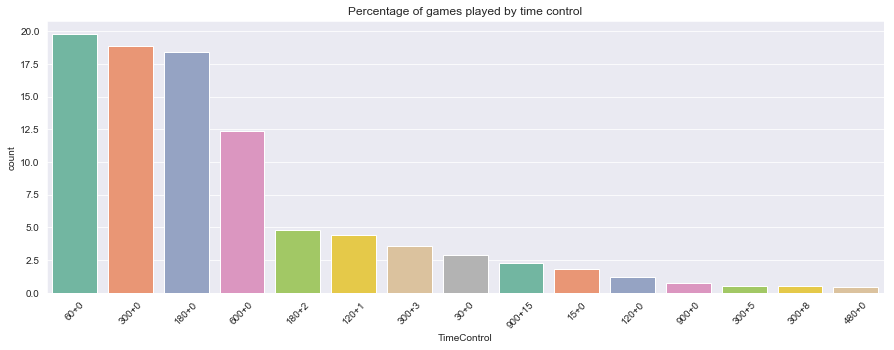

In [18]:
# Plotting data
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 5))
sns.set_style('darkgrid')
sns.barplot(data=types.head(15), x='TimeControl', y='count', palette=sns.color_palette('Set2'))
plt.title('Percentage of games played by time control')
plt.xticks(rotation=45)

The most popular time control is the 60+0 which belongs to the Bullet category, with 19 % of games played. Next are the 300+0 from the Blitz category and 180+0 from Bullet. 

,count
game_type,
Blitz,25.305833
Bullet,55.999698
Long,0.067696
Rapid,18.626774


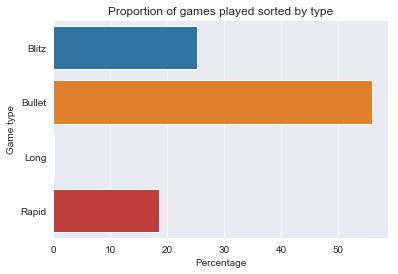

In [21]:
# Creating the total_time_per_player column
types['total_time_per_player'] = 0
for i in range(len(types)):
    row = types.loc[i, 'TimeControl']
    if not row == '-':
        types.loc[i, 'total_time_per_player'] = int(row.split('+')[0]) + 40 * int(row.split('+')[1])

# Classifying game types using total_time_per_player as a criterion
per_game = types.copy()
per_game['game_type'] = 'Correspondence'
per_game.loc[per_game['total_time_per_player'] < 43200, 'game_type'] = 'Long'
per_game.loc[per_game['total_time_per_player'] < 3600, 'game_type'] = 'Rapid'
per_game.loc[per_game['total_time_per_player'] < 600, 'game_type'] = 'Blitz'
per_game.loc[per_game['total_time_per_player'] < 300, 'game_type'] = 'Bullet'
per_game = per_game.groupby('game_type').sum()
sns.barplot(data=per_game.reset_index(), x='count', y='game_type')
plt.title('Proportion of games played sorted by type')
plt.xlabel('Percentage')
plt.ylabel('Game type')
per_game.drop(columns=['total_time_per_player'])

It turns out that Blitz and Bullet account to 80 % of the total number of games played. It is expected that shorter time controls games are played more often since there can be more games played per unit of time compared to longer time controls. Rapid and Blitz chess both englobes around one quarter of the games played, while the long games are a minority.

### What is the distribution of players' strengths?

Players performance is determined using the Elo rating system. A difference of 100 points betweem two opponents gives a probability of winning of 65% for the strongest player, and a difference of 200 points yields a probability of 76%. A new player is given a score of 1500 on sign-up, and has his rating modified according to his performance in rated games.

To get the distribution of ratings, we are going to get the list of players in both ```White``` and ```Black``` columns along with their rating. If a players played many games, only the first occurence is kept. We then JOIN the two tables and plot the distribution.

In [22]:
# Getting distinct player names and ratings from white and black
df1 = df.select("White", "WhiteElo").withColumnRenamed('White', 'Player').withColumnRenamed('WhiteElo', 'Elo').dropDuplicates(['Player'])
df2 = df.select("Black", "BlackElo").withColumnRenamed('Black', 'Player').withColumnRenamed('BlackElo', 'Elo').dropDuplicates(['Player'])
df1.createOrReplaceTempView("white")
df2.createOrReplaceTempView("black")

# Joining the two tables
query = """SELECT white.Player, COALESCE(white.Elo, black.Elo) AS Elo
FROM white FULL OUTER JOIN black
ON white.Player=black.Player"""

strengths = spark.sql(query).toPandas()

strengths = strengths.drop(strengths[strengths['Elo'] == 1500].index) # remove the 1500-elo players
x = list(strengths['Elo'].astype(float))

Mean: 1493.33
Median: 1500.00
Standard deviation: 279.37
10th percentile: 1130.00
90th percentile: 1862.00


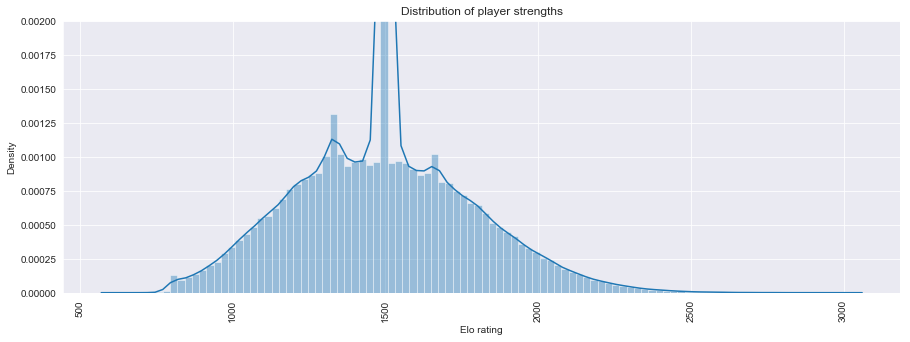

In [23]:
# Plotting data
fig = plt.figure(figsize=(15, 5))
plt.title('Distribution of player strengths')
plt.xticks(rotation=90)
plt.ylim(0, 0.002)
plt.xlabel('Elo rating')
plt.ylabel('Density')
sns.distplot(x, bins=100)


import statistics
import numpy as np
print ('Mean: %.2f' % statistics.mean(x))
print ('Median: %.2f' % statistics.median(x))
print ('Standard deviation: %.2f' % statistics.stdev(x))
print ('10th percentile: %.2f' % np.percentile(x, 10))
print ('90th percentile: %.2f' % np.percentile(x, 90))

After removing the idle players with an Elo rating of 1500, we still see a high density of players with Elo around 1500, due to the fact that lots of players sign up and stop after playing only a few games. The median is at 1500, the 10th and 90th percentiles as 1130 and 1862 respectively

### What are the most popular openings per player strength?

One other question we might ask is: what are the most popular openings out there ? Are skilled players using the same openings as beginners ? And how does a given opening's popularity evolve as the level of player increase ? The meta-data contains information about the specific opening variation that is used. There are more than 1800 different variatrions in the dataset. We are only going to look at the most popular among beginner, middle-level and skilled players. 

In [24]:
popular_openings = ["Van'tKruijsOpening",
 'SicilianDefense:BowdlerAttack',
 'ScandinavianDefense',
 'OldBenoniDefense',
 'ModernDefense',
 "King'sPawnGame:WaywardQueenAttack",
 'HungarianOpening']

In [63]:
# Split the DataFrame per elo ranges for performance
def save_elo_slices(elo_start, elo_end, incr, df):
    df.createOrReplaceTempView('openings')
    for i in range(int((elo_end - elo_start) / incr)):
        lower_bound = incr * i + elo_start
        upper_bound = incr * (i + 1) + elo_start
        query = """SELECT *
        FROM openings WHERE (WhiteElo + BlackElo)/2 >= {} and (WhiteElo + BlackElo)/2 < {}""".format(lower_bound, upper_bound)
        temp = spark.sql(query)
        temp.write.save('elo_range_{}-{}.parquet'.format(lower_bound, upper_bound))
save_elo_slices(1000, 2200, 100, df)

In [92]:
# For a given elo range, returns the count by opening and the total number of games
def opening_count(elo_start, elo_end, openings):
    df = spark.read.load('elo_range_{}-{}.parquet'.format(elo_start, elo_end))
    total_count = df.count()
    res = df.where(df.Opening.isin(openings)).groupBy('Opening').count().toPandas()
    
    a = pd.DataFrame({'Opening':openings})
    res = res.merge(a, on='Opening', how='outer').sort_values(by='Opening', ascending=False).fillna(0)
    
    return res, total_count

In [97]:
# Generate openings counts sorted by elo range
elo_start = 1000
elo_end = 2200
incr = 50
result = {}

for i in range(int((elo_end - elo_start) / incr)):
    lower_bound = incr * i + elo_start
    upper_bound = incr * (i + 1) + elo_start
    data, total_count = opening_count(lower_bound, upper_bound, popular_openings)
    if len(data) > 0:
            count = data['count'].tolist()
            values = {'total_count': total_count, 'counts': count}
            result['{} - {}'.format(lower_bound, upper_bound)] = values

In [98]:
# Extract the count serie for each opening for plotting
lines = {}
for op_id in range(len(popular_openings)):
    line = []
    for bound in result.keys():
        line.append(result[bound]['counts'][op_id] / result[bound]['total_count'])
    lines[popular_openings[op_id]] = line

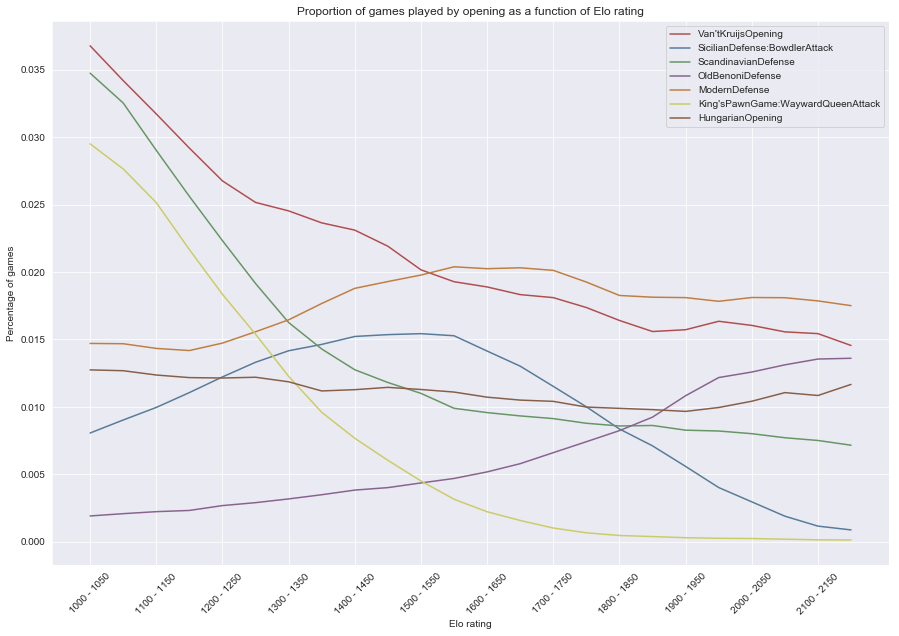

In [99]:
# Plotting data
fig = plt.figure(figsize=(15, 10))
sns.set_palette('Reds', 4)
counter = 0
for opening in list(popular_openings):
    counter += 1
    y = lines[opening]
    with sns.color_palette("Set1", n_colors=7, desat=.5):
        ax = sns.lineplot(x=range(len(result.keys())), y=y, label=opening, markers=True, dashes=[(2, 2)])
        xticks = range(0, len(result.keys()), 2)
        ax.set(xticks=xticks)
        ax.set(xticklabels=[list(result.keys())[i] for i in xticks if i % 2 == 0])
        plt.xticks(rotation=45)
        plt.xlabel('Elo rating')
        plt.ylabel('Percentage of games')
        plt.title('Proportion of games played by opening as a function of Elo rating')

The Van't Kruijs Opening is very popular at the low-levels, and lose popularity to almost 0% of usage in the highest levels. This opening is characterized by the opening move 1. e3, which is the most intuitive amd simple move to play for an amateur. This opening is however considered as too passive, which is the reason why players that have a deep understanding of opening dynamics don't use it

The Sicilian Defense: Bowdler Attack rise in popularity until elo 1500 and become unpopular in the highest levels of play. This variant of the Sicilian Defense is played because it quickly develops white's attacking pieces, which is appealing to the eyes of a beginner. However it is not optimal and black has several way to refute it, which is way stronger players abandon this variant.

Some openings like the Hungarian opening or the Modern Defense, while being completely unpopular both for low and middle levels, gradually gains in popularity and becomes the most used openings for the 2400+. Beginning with 1. g3 and planning a control of the center with Bg2, the Hungarian opening is typical of the hypermodern school of thought that claims games can be won by indirect control of the center instead of its occupation. (occupation the center have been the basis of the previous chess schools of thought). The modern defense is characterized by the first moves 1. e4 g6, where it is now black that is trying to get control from the center at distance.

At low levels, the top openings have higher percentages of occurences, as the opening reperoire of players at those levels are reduced. We see that at high levels, the top opening is played 1.8% of the time, indicating a more extensive choice.

### What is the most effective opening per player strength and per game type

We've seen which openings were the most popular among the different play levels, but what about their effectiveness at winning the game ? Does the most widely used openings lead to the highest win / loss ratios ? And are there some niche openings that few people know and that are really effective ? Let's perform the same analysis as in the previous question by focusing this time on the win / loss ratios of openings.

In [115]:
def result_count(elo_start, elo_end, opening):
    df = spark.read.load('elo_range_{}-{}.parquet'.format(elo_start, elo_end)).select('Result', 'Opening')
    df = df.filter(df['Opening'] == opening).groupBy('Result').count().toPandas()
    
    b = pd.DataFrame({'Result': ['1/2-1/2', '1-0', '0-1']})
    res = df.merge(b, on='Result', how='outer').sort_values(by='Result', ascending=False).fillna(0)

    return res

In [116]:
elo_start = 1000
elo_end = 2200
incr = 100
bounds = []
data ={}


for opening in popular_openings:
    values = {}
    for i in range(int((elo_end - elo_start) / incr)):
        lower_bound = incr * i + elo_start
        upper_bound = incr * (i + 1) + elo_start
        res = result_count(lower_bound, upper_bound, opening)
        draws = res[res['Result'] == '1/2-1/2']['count'].values[0]
        wins = res[res['Result'] == '1-0']['count'].values[0]
        losses = res[res['Result'] == '0-1']['count'].values[0]
        values['{} - {}'.format(lower_bound, upper_bound)] = {'draws': draws, 'wins':wins, 'losses':losses}
    data[opening] = values

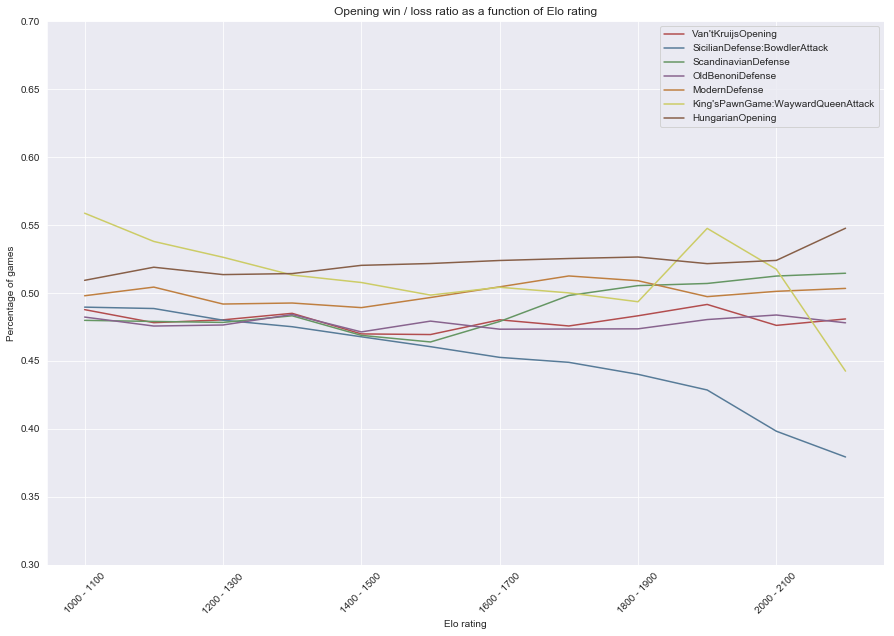

In [122]:
fig = plt.figure(figsize=(15, 10))
counter = 0

for opening in data.keys():
    line = []
    counter += 1
    for bound in data[opening].keys():
        total_count = data[opening][bound]['wins'] + data[opening][bound]['losses']
        line.append(data[opening][bound]['wins'] / total_count)
    with sns.color_palette("Set1", n_colors=7, desat=.5):
        ax = sns.lineplot(x=range(len(data[opening].keys())), y=line, label=opening)
        xticks = range(0, len(data[opening].keys()), 2)
        ax.set(xticks=xticks)
        ax.set(xticklabels=[list(data[opening].keys())[i] for i in xticks if i % 2 == 0])
        plt.xticks(rotation=45)
        plt.xlabel('Elo rating')
        plt.ylabel('Percentage of games')
        plt.title('Opening win / loss ratio as a function of Elo rating')
        plt.ylim(0.3, 0.7)

Surprisingly, the Van't Krujis Opening which is the most popular until Elo 1400 is always ineffective for white as black has higher chances of winning. The most played openings are not necessarily the most efficient. The Bowdler attack variant from the Sicilian Defense, which is the most played variant at lower levels, is also inefficient and becomes really dangerous to use at higher levels as players know of to play against it. From the openings we chose, only the Hungarian opening allows white to reach their average winning ratio of 52%.

### How does white do compared to black per player strength and game type

In chess, it is well-known that white always have a slight advantage because they are allowed to move first. However, how is this advantage exploited by players from lichess ? And does the time control have an effect on the capacity of to use this advantage ? 

In [101]:
from pyspark.sql.functions import split

def filter_game_type(df):
    # Splitting Time control column into FixedTime and TimeIncrement
    split_col = split(df['TimeControl'], '\+')
    df = df.withColumn('FixedTime', split_col.getItem(0))
    df = df.withColumn('40 x TimeIncrement', 40 * split_col.getItem(1))

    # Setting TotalTime as FixedTime + 40 * TimeIncrement
    df = df.withColumn("TotalTime", sum(df[col] for col in ['FixedTime', '40 x TimeIncrement']))

    # Game type DataFrames
    bullet = df.filter(df['TotalTime'] <= 300)
    blitz = df.filter((df['TotalTime'] > 300) & (df['TotalTime'] <= 600))
    rapid = df.filter((df['TotalTime'] > 600) & (df['TotalTime'] <= 3600))
    long = df.filter(df['TotalTime'] > 3600)
    
    results = {}
    names = ['bullet', 'blitz', 'rapid', 'long']
    counter = 0
    
    b = pd.DataFrame({'Result': ['1/2-1/2', '1-0', '0-1']})
    for game_type_df in [bullet, blitz, rapid, long]:
        a = game_type_df.groupBy('Result').count().toPandas()
        res = a.merge(b, on='Result', how='outer').sort_values(by='Result', ascending=False).fillna(0)
        results[names[counter]] = res
        counter += 1
    
    return results

In [102]:
values = {}
elo_start = 1000
elo_end = 2200
incr = 100
for i in range(int((elo_end - elo_start) / incr)):
    lower_bound = incr * i + elo_start
    upper_bound = incr * (i + 1) + elo_start
    df = spark.read.load('elo_range_{}-{}.parquet'.format(lower_bound, upper_bound))
    results = filter_game_type(df)

    values['{} - {}'.format(lower_bound, upper_bound)] = results

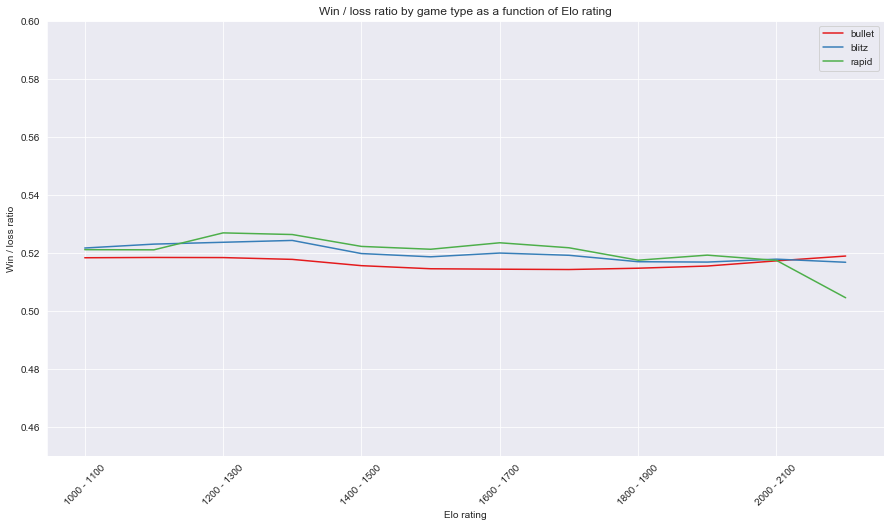

In [109]:
fig = plt.figure(figsize=(15, 8))
sns.set_palette('Set1', 15)

# Computing win / loss ratio and plotting
for game_type in ['bullet', 'blitz', 'rapid']:
    line = []
    for bound in values.keys():
        d = values[bound][game_type]
        wins = d[d['Result'] == '1-0']['count'].values[0]
        losses = d[d['Result'] == '0-1']['count'].values[0]
        line.append(wins / (wins + losses))
    plt.ylim(0.45, 0.6)
    with sns.color_palette("Set1", n_colors=7, desat=.5):
        ax = sns.lineplot(x=range(len(values.keys())), y=line, label=game_type, markers=True)
        xticks = range(0, len(values.keys()), 2)
        ax.set(xticks=xticks)
        ax.set(xticklabels=[list(values.keys())[i] for i in xticks if i % 2 == 0])
        plt.xticks(rotation=45)
        plt.xlabel('Elo rating')
        plt.ylabel('Win / loss ratio')
        plt.title('Win / loss ratio by game type as a function of Elo rating')

As expected, we see that whites have a slight advantage due to the fact that they play first and hence have the initiative. What is interesting in that the quicker the game type, the smaller this advantage. In fast-chess, players may have less time to really exploit white's initiative as there are more inaccurate moves played.

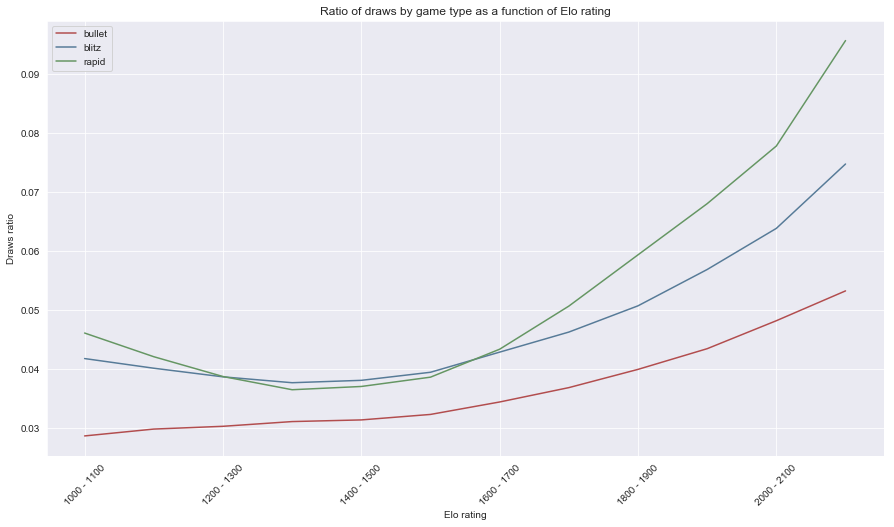

In [114]:
fig = plt.figure(figsize=(15, 8))
sns.set_palette('Set1', 15)

# Computing draw ratio and plotting
for game_type in ['bullet', 'blitz', 'rapid']:
    line = []
    for bound in values.keys():
        d = values[bound][game_type]
        draws = d[d['Result'] == '1/2-1/2']['count'].values[0]
        wins = d[d['Result'] == '1-0']['count'].values[0]
        losses = d[d['Result'] == '0-1']['count'].values[0]
        line.append(draws / (draws + wins + losses))
#     plt.ylim(0.45, 0.6)
    with sns.color_palette("Set1", n_colors=7, desat=.5):
        ax = sns.lineplot(x=range(len(values.keys())), y=line, label=game_type, markers=True)
        xticks = range(0, len(values.keys()), 2)
        ax.set(xticks=xticks)
        ax.set(xticklabels=[list(values.keys())[i] for i in xticks if i % 2 == 0])
        plt.xticks(rotation=45)
        plt.xlabel('Elo rating')
        plt.ylabel('Draws ratio')
        plt.title('Ratio of draws by game type as a function of Elo rating')

Since in slower games players are given more time to think, moves are more accurate and positions stay balanced more often, resulting in a higher number of draws. Moreover, skilled players make less blunders and hence get to more drawish positions than less skilled players. At the highest levels of play, draws represent 10% of the games.

### Comparison of the Queen's Gambit opening lines

Queen's Gambit is an opening that involves the (temporary) sacrifice of a pawn for white in order to get an advance in development. Being personnally fond of this openings, I find interesting to see the performance of the main variant lines. There are 197 different variants in the dataset associated to this opening, so it is impossible to study each of them. Variants can however by grouped by theoretical line, e.g. Queen's Gambit Declined or Queen's Gambit Accepted, which makes the opening easier to study. We are going to look at the most popular theoretical lines only

In [123]:
qg = ["Queen'sGambitAccepted:CentralVariation",
      "Queen'sGambitRefused:AlbinCountergambit",
      "Queen'sGambitRefused:ChigorinDefense",
      "Queen'sGambitDeclined",
      "Queen'sGambitAccepted"]

In [124]:
def opening_result_count(elo_start, elo_end, opening):
    df = spark.read.load('elo_range_{}-{}.parquet'.format(elo_start, elo_end)).select('Result', 'Opening')
    df = df.filter(df.Opening.contains(opening)).groupBy('Result').count().toPandas()
    
    b = pd.DataFrame({'Result': ['1/2-1/2', '1-0', '0-1']})
    res = df.merge(b, on='Result', how='outer').sort_values(by='Result', ascending=False).fillna(0)

    return res

In [125]:
elo_start = 1000
elo_end = 2200
incr = 100
bounds = []
data ={}


for opening in qg:
    values = {}
    for i in range(int((elo_end - elo_start) / incr)):
        lower_bound = incr * i + elo_start
        upper_bound = incr * (i + 1) + elo_start
        res = opening_result_count(lower_bound, upper_bound, opening)
        draws = res[res['Result'] == '1/2-1/2']['count'].values[0]
        wins = res[res['Result'] == '1-0']['count'].values[0]
        losses = res[res['Result'] == '0-1']['count'].values[0]
        values['{} - {}'.format(lower_bound, upper_bound)] = {'draws': draws, 'wins':wins, 'losses':losses}
    data[opening] = values

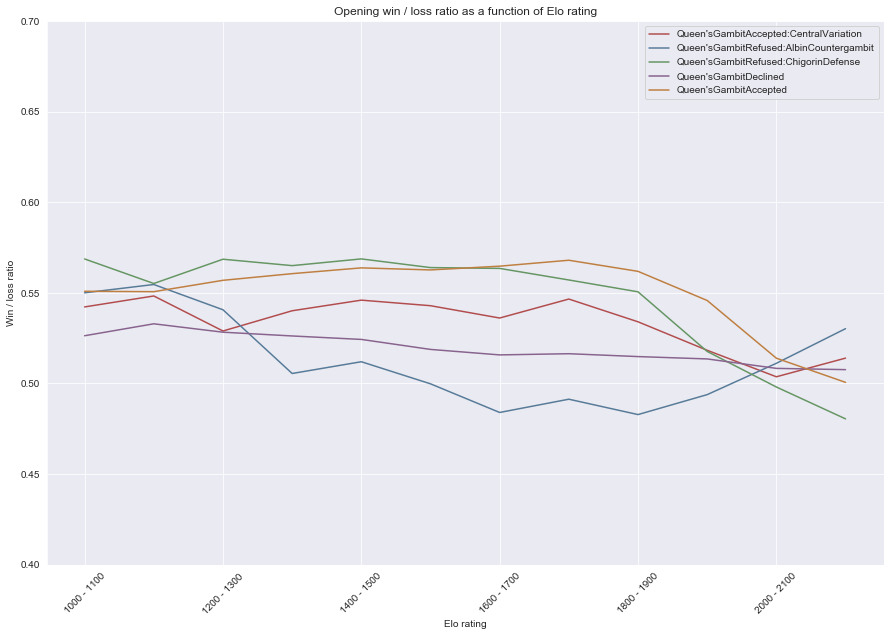

In [126]:
fig = plt.figure(figsize=(15, 10))
sns.set_palette('Set1', 15)
counter = 0

lines = {}
for opening in data.keys():
    counter += 1
    line = []
    for bound in data[opening].keys():
        draws = data[opening][bound]['draws']
        wins = data[opening][bound]['wins']
        losses = data[opening][bound]['losses']
        total_count = draws + wins + losses
        line.append(wins / total_count)
    
    with sns.color_palette("Set1", n_colors=6, desat=.5):
        ax = sns.lineplot(x=range(len(data[opening].keys())), y=line, label=opening)
        xticks = range(0, len(data[opening].keys()), 2)
        ax.set(xticks=xticks)
        ax.set(xticklabels=[list(data[opening].keys())[i] for i in xticks if i % 2 == 0])
        plt.xticks(rotation=45)
        plt.xlabel('Elo rating')
        plt.ylabel('Win / loss ratio')
        plt.title('Opening win / loss ratio as a function of Elo rating')
        plt.ylim(0.4, 0.7)

Queen's Gambit openings perform better than the average which is at 52% of win. More importantly, accepting the gambit lead to a higher chance of losing the game for black than refusing it. However, this pattern begins to vanish at Elo 1800 and disappear at Elo 2100, where both openings have the same performance. It appears that stronger players with Elo above 2100 don't achieve high performance using this opening. Being myself a player at Elo around 1500, I can be reassured as I still have some time ahead playing the queen's gambit.

## Conclusion

In this project we have seen how to use PySpark to explore a large dataset. The various analyses shown lead to some insights about how people play on online chess. There can still be a lot to be done on this dataset by taking clock times and chess moves into considerations. New questions to be answered could be: what openings lead to the longer games? Or, what openings lead to the most blunders during the game ? 

The computation time was a major limitation for doing this analysis. However, by using a cluster of nodes instead of a single node, the code can run much faster with little adaptation. In this project we only used 3 months of data, or 55 million chessgames. By using more data the results would be much more accurate, especially when looking at data from some niche openings for example.